# CREDIT CARD DEFAULT RISK CLASSIFICATION MODELS - MODELOS DE CLASSIFICACION PARA RIESGO CREDITICIO

In [1]:
#Importacion de librerias 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn import metrics

In [2]:
#importacion del dataset

df = pd.read_csv('../Data/credit_risk_dataset.csv')
df

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36886,CST_130421,Doris,55,F,N,N,2.0,96207.57,117.0,Unknown,4.0,0.0,11229.54,29663.83,82,907.0,0,0,0
36887,CST_136670,Luciana,31,F,N,Y,0.0,383476.74,966.0,Accountants,2.0,1.0,43369.91,139947.16,32,679.0,0,0,0
36888,CST_145435,Jessica,27,F,N,Y,0.0,260052.18,1420.0,Core staff,2.0,0.0,22707.51,83961.83,46,727.0,0,0,0
36889,CST_130913,Tessa,32,M,Y,N,0.0,157363.04,2457.0,Laborers,2.0,0.0,20150.10,25538.72,92,805.0,0,0,0


In [3]:
#Eliminacion de variables no necesarias
df = df.drop(['customer_id', 'name'], axis=1)

# Preprocesamiento de los datos

In [4]:
#Usaremos label encoder para convertir las variables categoricas en numericas
label_encoder = LabelEncoder()

#Seleccionamos las variables categoricas
cat_cols = df.select_dtypes(include=['object']).columns

#Aplicamos label encoder a las variables categoricas
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])

#Verificamos que se hayan convertido las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36891 entries, 0 to 36890
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      36891 non-null  int64  
 1   gender                   36891 non-null  int64  
 2   owns_car                 36891 non-null  int64  
 3   owns_house               36891 non-null  int64  
 4   no_of_children           36891 non-null  float64
 5   net_yearly_income        36891 non-null  float64
 6   no_of_days_employed      36891 non-null  float64
 7   occupation_type          36891 non-null  int64  
 8   total_family_members     36891 non-null  float64
 9   migrant_worker           36891 non-null  float64
 10  yearly_debt_payments     36891 non-null  float64
 11  credit_limit             36891 non-null  float64
 12  credit_limit_used(%)     36891 non-null  int64  
 13  credit_score             36891 non-null  float64
 14  prev_defaults         

In [5]:
#utilizamos train_test_split para dividir el dataset en entrenamiento y prueba
x = df.drop('credit_card_default', axis=1)
y = df['credit_card_default']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y ,random_state=42)

print('Dataset de entrenamiento: ', x_train.shape, y_train.shape)
print('Dataset de prueba: ', x_test.shape, y_test.shape)

Dataset de entrenamiento:  (25823, 16) (25823,)
Dataset de prueba:  (11068, 16) (11068,)


In [6]:
#Utilizamos standarscaler para escalar las variables numericas
scaler = StandardScaler()

#Seleccionamos las variables numericas
cols = x_train.columns
x_train[cols] = scaler.fit_transform(x_train[cols])
x_test[cols] = scaler.transform(x_test[cols])

In [7]:
x_train.head()

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
6591,-0.942964,1.300823,-0.753831,0.685606,-0.647850,0.333013,-0.130351,1.252495,-0.266685,-0.528564,0.064738,-0.406860,1.514194,1.249545,-0.238337,-0.239513
23947,1.468939,1.300823,1.326556,-1.458563,0.669324,0.106005,-0.058275,-0.261336,0.794262,-0.528564,2.883371,0.345660,0.460564,0.150736,-0.238337,-0.239513
1916,1.364074,-0.768744,1.326556,0.685606,-0.647850,1.997007,-0.129456,1.441724,-1.327631,-0.528564,-1.129369,1.217510,-1.034911,1.239646,-0.238337,-0.239513
25659,1.573804,-0.768744,-0.753831,0.685606,-0.647850,0.121834,3.023096,-0.261336,-0.266685,-0.528564,-0.955173,-0.446237,-0.796995,1.299041,-0.238337,-0.239513
11179,0.944612,1.300823,1.326556,0.685606,0.669324,0.621154,-0.020222,-0.261336,0.794262,-0.528564,0.051207,1.715338,-1.340804,0.061644,-0.238337,-0.239513


Teniendo en cuenta que nuestro Dataset presenta un evidente desbalance de clases, utilizaremos el metodo SMOTE para equilibrar el entrenamiento del dataset y contrarrestar el efecto que podria tener en el modelo.

In [8]:
#Smote para balancear las clases
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

print('Dataset de entrenamiento balanceado: ', x_train.shape, y_train.shape)
print('Dataset de prueba balanceado: ', x_test.shape, y_test.shape)

Dataset de entrenamiento balanceado:  (47122, 16) (47122,)
Dataset de prueba balanceado:  (11068, 16) (11068,)


# MODELO K-Nearest Neighbors (KNN) 

El valor óptimo de K es: 3


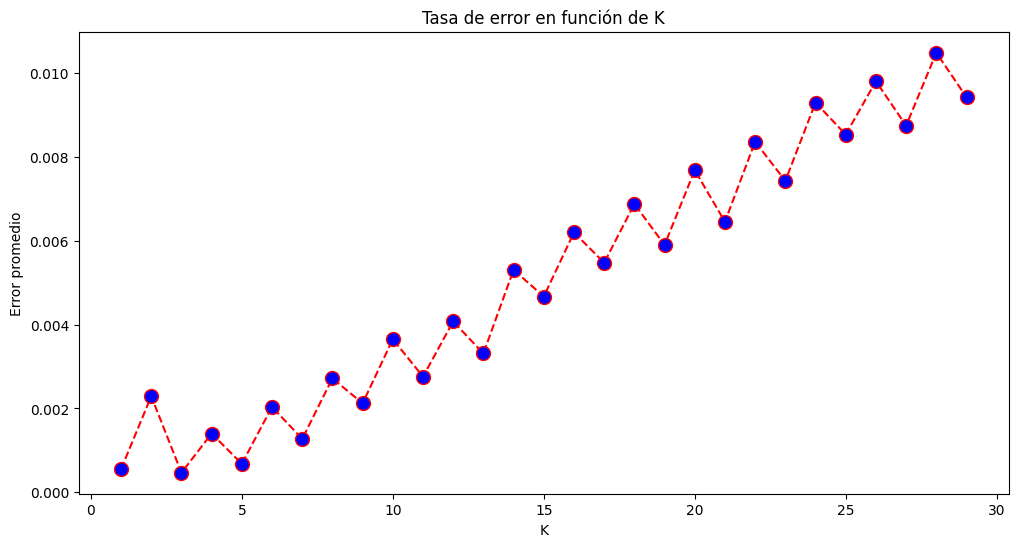

In [9]:
# Iteramos el modelo KNN con diferentes valores de K desde k = 1 hasta k = 30
from sklearn.neighbors import KNeighborsClassifier

error = []

# Definimos validacion cruzada estraificada con 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculamos el error para los valores de K entre 1 y 30
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores= cross_val_score(knn, x_train, y_train, cv=kf, scoring='recall')
    error.append(1 - scores.mean())

# Encontramos el valor de K con el menor error
k_optimo = error.index(min(error)) + 1
print(f'El valor óptimo de K es: {k_optimo}')

# Graficamos el error en función de los valores de K
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Tasa de error en función de K')
plt.xlabel('K')
plt.ylabel('Error promedio')
plt.show()

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, make_scorer
# Inicializamos el modelo KNN con el valor de K óptimo encontrado k = 3
knn = KNeighborsClassifier(n_neighbors=3)

# Definimos validacion cruzada estraificada con 5 folds para validacion del modelo
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializamos las metricas de evaluacion
accuracy_scores = cross_val_score(knn, x_train, y_train, cv=kf, scoring='recall')
precision_scores = cross_val_score(knn, x_train, y_train, cv=kf, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(knn, x_train, y_train, cv=kf, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(knn, x_train, y_train, cv=kf, scoring=make_scorer(f1_score))

# Calculamos AUC de forma independiente ya que debemos calcular probabilidades
auc_scores = []
for train_index, test_index in kf.split(x_train, y_train):
    x_cv_train, x_cv_test = x_train.iloc[train_index], x_train.iloc[test_index]
    y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]
    knn.fit(x_cv_train, y_cv_train)
    y_pred_prob = knn.predict_proba(x_cv_test)[:, 1]
    auc_scores.append(roc_auc_score(y_cv_test, y_pred_prob))

# Resultados de la validacion cruzada
print('Resultados de la validación cruzada:')
print(f'Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Precision: {np.mean(precision_scores):.4f}')
print(f'Recall: {np.mean(recall_scores):.4f}')
print(f'F1 Score: {np.mean(f1_scores):.4f}')
print(f'AUC Score: {np.mean(auc_scores):.4f}')

# Entrenamos el modelo KNN con el dataset de entrenamiento
knn.fit(x_train, y_train)

# Realizamos predicciones con el dataset de prueba
y_pred = knn.predict(x_test)

# Calculamos las metricas de evaluacion
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)
roc_auc_knn = roc_auc_score(y_test, y_pred)

#Capturamos las metricas de evaluacion en un diccionario
metricas_knn = {
    'Modelo': 'KNN',
    'Accuracy': accuracy_knn,
    'Precision': precision_knn, 
    'Recall': recall_knn, 
    'F1 Score': f1_knn, 
    'AUC': roc_auc_knn
}

print()
# Matriz de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

print()
# Reporte de clasificacion
class_report = classification_report(y_test, y_pred)
print('Reporte de clasificación:')
print(class_report)
print()

# Imprimimos las metricas de evaluacion
print('Metricas de evaluacion con datos de prueba:')
print(f'Accuracy: {accuracy_knn:.4f}')
print(f'Precision: {precision_knn:.4f}')
print(f'Recall: {recall_knn:.4f}')
print(f'F1 Score: {f1_knn:.4f}')
print(f'AUC Score: {roc_auc_knn:.4f}')

Resultados de la validación cruzada:
Accuracy: 0.9995
Precision: 0.9488
Recall: 0.9995
F1 Score: 0.9735
AUC Score: 0.9872

Matriz de confusión:
[[9596  503]
 [ 141  828]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     10099
           1       0.62      0.85      0.72       969

    accuracy                           0.94     11068
   macro avg       0.80      0.90      0.84     11068
weighted avg       0.95      0.94      0.95     11068


Metricas de evaluacion con datos de prueba:
Accuracy: 0.9418
Precision: 0.6221
Recall: 0.8545
F1 Score: 0.7200
AUC Score: 0.9023


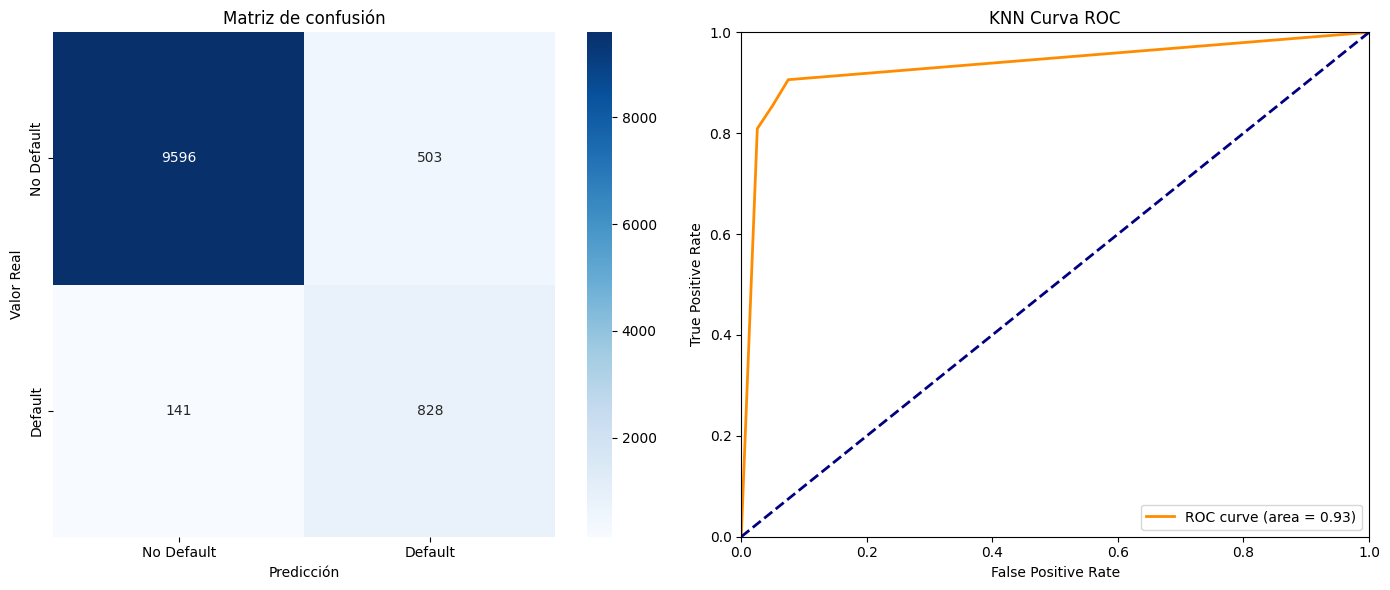

In [80]:
plt.figure(figsize=(14, 6))

# Matriz de confusion
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks([0.5, 1.5], ['No Default', 'Default'])
plt.yticks([0.5, 1.5], ['No Default', 'Default'])

# Curva ROC
plt.subplot(1, 2, 2)
y_pred_prob = knn.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Curva ROC')
plt.legend(loc='lower right')

plt.tight_layout()


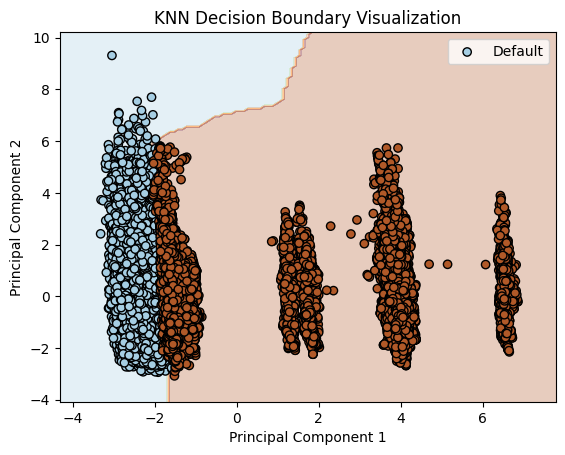

In [89]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dataset to 2 features
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)

knn.fit(x_train_pca, y_train)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = x_train_pca[:, 0].min() - 1, x_train_pca[:, 0].max() + 1
y_min, y_max = x_train_pca[:, 1].min() - 1, x_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict classes for each point in the mesh grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, edgecolors='k', marker='o', cmap=plt.cm.Paired)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KNN Decision Boundary Visualization')
plt.legend(['Default', 'No Default'])
plt.show()

# Modelo # XGBOOST 

In [81]:
#Inicializamos el modelo
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', #Para problemas de clasificacion binaria
    eval_metric='logloss', #Metrica de evaluacion logloss para problemas de clasificacion binaria
    scale_pos_weight=len(y_train) / sum(y_train), # Peso de las clases desbalanceadas
    random_state=42 #Semilla aleatoria para reproducibilidad
)
#Definimos los hiperparametros para el metodo de RandomizedSearchCV
params = {
    'n_estimators': [100, 150], #Numero de arboles
    'max_depth': [5, 10], #Profundidad de los arboles
    'learning_rate': [0.01, 0.1], #Tasa de aprendizaje
    'subsample': [0.8, 0.9], #Muestra de filas para entrenar cada arbol
    'min_child_weight': [1, 3] #Peso minimo de las hojas de los arboles
}

#Definimos Kfold Estraficada para validacion cruzada
str_kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) #Validacion cruzada estratificada

#definimos metricas de evaluacion
scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score), #Exactitud
    'precision': metrics.make_scorer(metrics.precision_score, average='binary'), #Precision
    'recall': metrics.make_scorer(metrics.recall_score, average='binary'), #Recall
    'f1': metrics.make_scorer(metrics.f1_score, average='binary'), #F1 Score
    'roc_auc': 'roc_auc' #AUC Score
}    

#Definimos RandomizedSearchCV
r_search_xgb = RandomizedSearchCV(  # Busqueda aleatoria de hiperparametros con validacion cruzada estratificada
    estimator=xgb_model,  # Modelo a utilizar
    param_distributions=params, # Hiperparametros a optimizar
    scoring=scoring, # Metricas de evaluacion
    refit='recall', # Metrica a optimizar en el modelo
    n_iter=20, # Numero de iteraciones
    cv= str_kf, # Validacion cruzada estratificada
    verbose=3, # Detalle del proceso
    n_jobs=-1 # Uso de todos los nucleos del procesador
)

#Entrenamos el modelo
r_search_xgb.fit(x_train, y_train) 

#Mejores parametros
print('Mejores parametros: ', r_search_xgb.best_params_) # Mejores hiperparametros
print('Mejor Score: ', r_search_xgb.best_score_)  # Mejor Recall
print() 
print('Mejor Modelo: ', r_search_xgb.best_estimator_) # Mejor modelo 
print()

#Evaluando el mejor modelo
mejor_modelo = r_search_xgb.best_estimator_ 
y_pred = mejor_modelo.predict(x_test) #Prediccion del modelo en el dataset de prueba

#Capturamos las metricas de evaluacion en un diccionario
metricas_xgb = {
    'Modelo': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred), 
    'Recall': recall_score(y_test, y_pred), 
    'F1 Score': f1_score(y_test, y_pred), 
    'AUC': roc_auc_score(y_test, y_pred)
}

#Reporte de clasificacion
print('Reporte de clasificacion: ')
print(classification_report(y_test, y_pred)) 
print()

#Matriz de confusion
print('Matriz de confusion: ')
confusion_matrix(y_test, y_pred)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Mejores parametros:  {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01}
Mejor Score:  0.999405808520897

Mejor Modelo:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Reporte de cl

array([[9566,  533],
       [   3,  966]])

In [82]:
# Calculamos probabilidades de predicción para AUC Score
y_pred_prob = mejor_modelo.predict_proba(x_test)[:, 1]

# Evaluamos metricas de clasificacion con el nuevo umbral
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# Imprimimos las metricas de evaluacion
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')

Accuracy: 0.9516
Precision: 0.6444
Recall: 0.9969
F1 Score: 0.7828
AUC: 0.9944


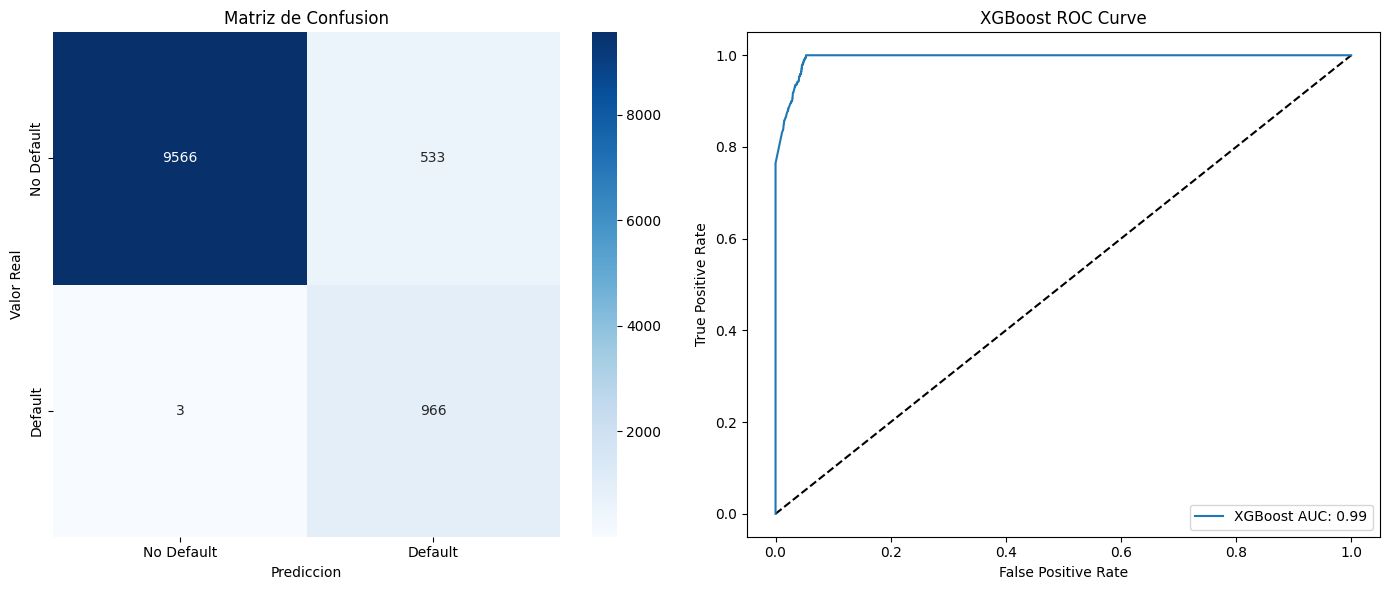

In [83]:
# Matriz de confusion en conteos
y_pred_prob = mejor_modelo.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'XGBoost AUC: {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusion')
plt.xlabel('Prediccion')
plt.ylabel('Valor Real')
plt.xticks([0.5, 1.5], ['No Default', 'Default'])
plt.yticks([0.5, 1.5], ['No Default', 'Default'])


plt.tight_layout()


Best Threshold: 0.8753
Best F1 Score: 0.8667


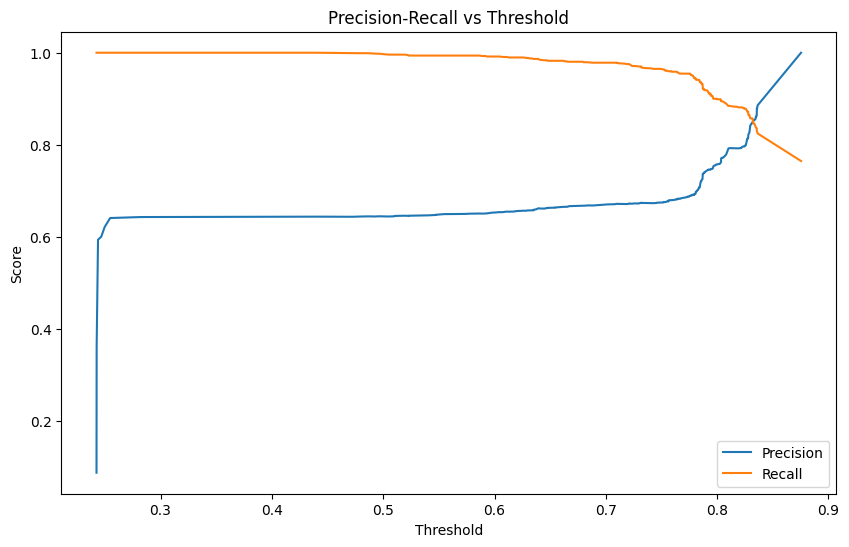

In [84]:
from sklearn.metrics import precision_recall_curve, f1_score

# Calculamos la probabilidad de predicción para la clase positiva
y_pred_prob = mejor_modelo.predict_proba(x_test)[:, 1]

# Calculamos la precision y recall para cada umbral de decisión
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Calculamos el F1 Score para cada umbral de decisión
f1_scores = 2 * (precision * recall) / (precision + recall)

# Encontramos el umbral de decisión que maximiza el F1 Score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1_score = f1_scores[best_index]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {best_f1_score:.4f}")

# Plot Precision-Recall vs Threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()


Dependiendo del tipo de problema y necesidad de negocio, puede que se requiera balancear el umbral de decision para obtener mejores resultados de precision vs recall. En nuestro caso no es necesario ya que al ser un problema de deteccion de incumplimiento, el objetivo es obtener el mayor puntaje posible de recall a costo de la precision. 

Sin embargo, en caso de requerir es posible cambiar el umbral de decision y balancear la precision a costo de recall. Como se puede observar en el ejemplo a continuacion:

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Calculamos probabilidades de predicción para AUC Score
y_pred_prob = mejor_modelo.predict_proba(x_test)[:, 1]

# Definimos un nuevo umbral de decisión
threshold = 0.83 
y_pred_threshold = (y_pred_prob >= threshold).astype(int)

# Evaluamos metricas de clasificacion con el nuevo umbral
accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
auc = roc_auc_score(y_test, y_pred_prob)

#Matriz de confusion
conf_matrix = confusion_matrix(y_test, y_pred_threshold)
print('Matriz de confusion:\n', conf_matrix)

# Imprimimos las metricas de evaluacion
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')

Matriz de confusion:
 [[9944  155]
 [ 138  831]]
Accuracy: 0.9735
Precision: 0.8428
Recall: 0.8576
F1 Score: 0.8501
AUC: 0.9943


                    Feature  Importance (%)
13             credit_score       79.521553
12     credit_limit_used(%)       17.912010
6       no_of_days_employed        0.493683
7           occupation_type        0.353308
10     yearly_debt_payments        0.305746
4            no_of_children        0.279287
5         net_yearly_income        0.223653
2                  owns_car        0.182280
0                       age        0.177447
11             credit_limit        0.158121
8      total_family_members        0.135165
9            migrant_worker        0.093555
1                    gender        0.088761
3                owns_house        0.075428
14            prev_defaults        0.000000
15  default_in_last_6months        0.000000


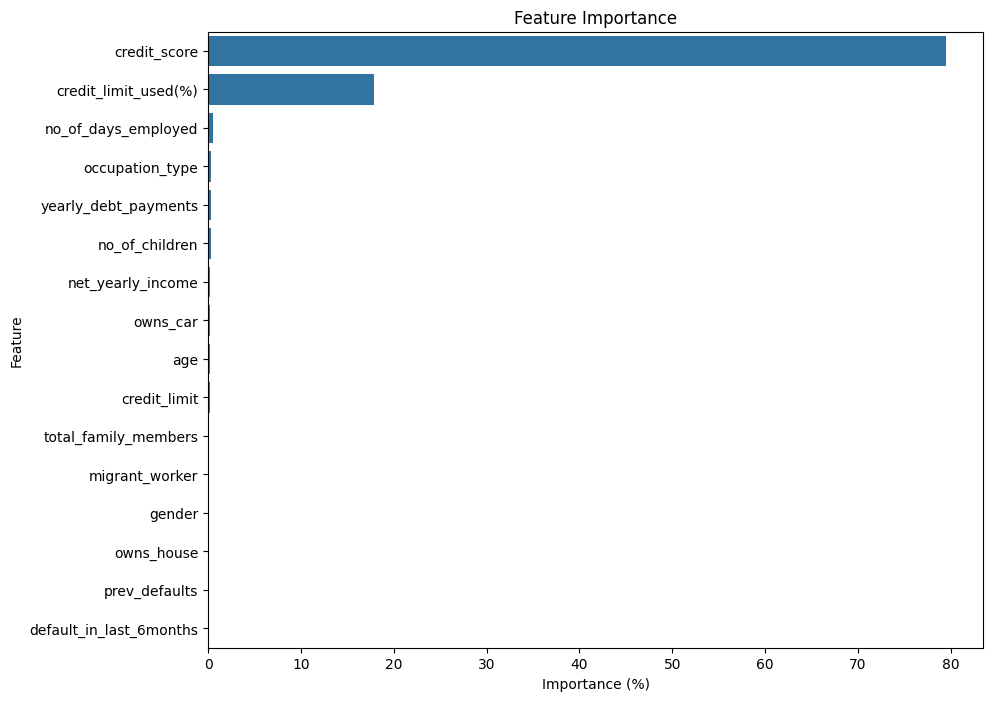

In [85]:
# Get feature importances from the best model
feature_importance = mejor_modelo.feature_importances_

# Normalize to percentage
feature_importance_percentage = 100.0 * (feature_importance / feature_importance.sum())

# Assuming x_train is a DataFrame and has column names
feature_names = pd.DataFrame(x_train).columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (%)': feature_importance_percentage
}).sort_values(by='Importance (%)', ascending=False)

# Print the feature importances
print(importance_df)

# Plot feature importance using Seaborn
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance (%)', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


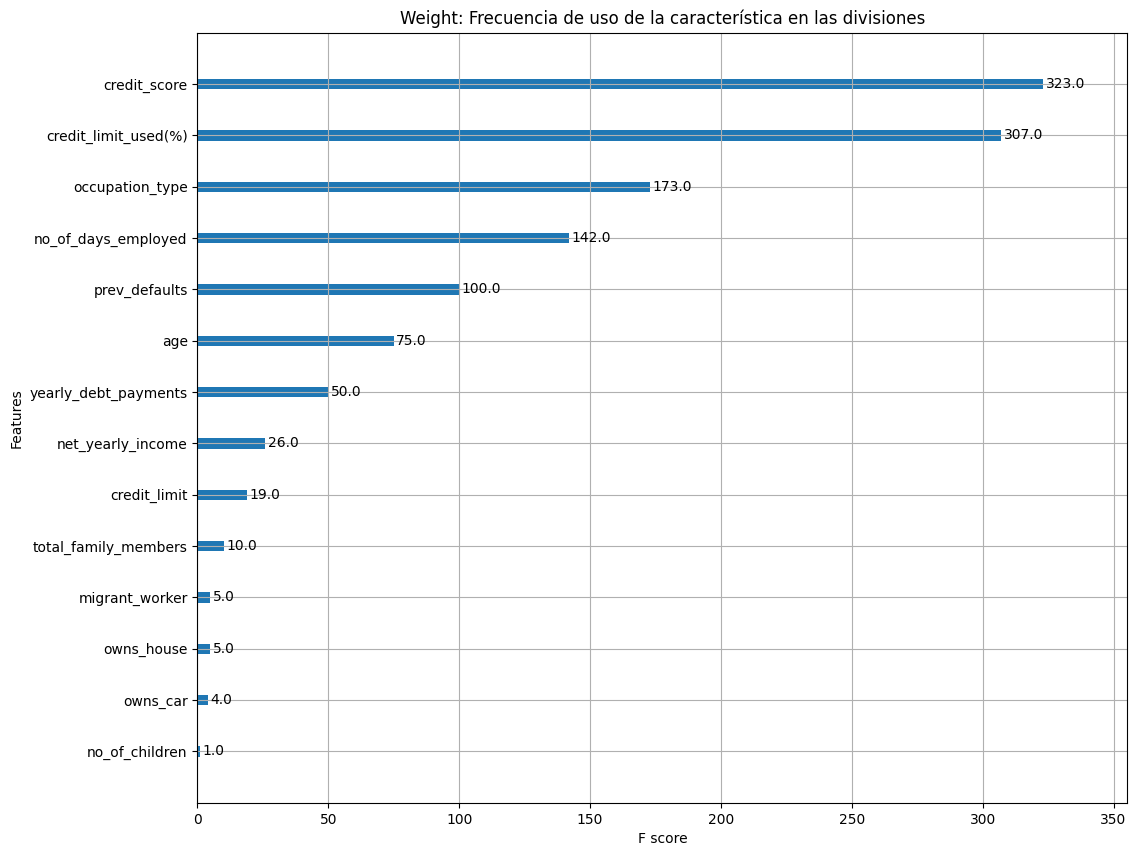

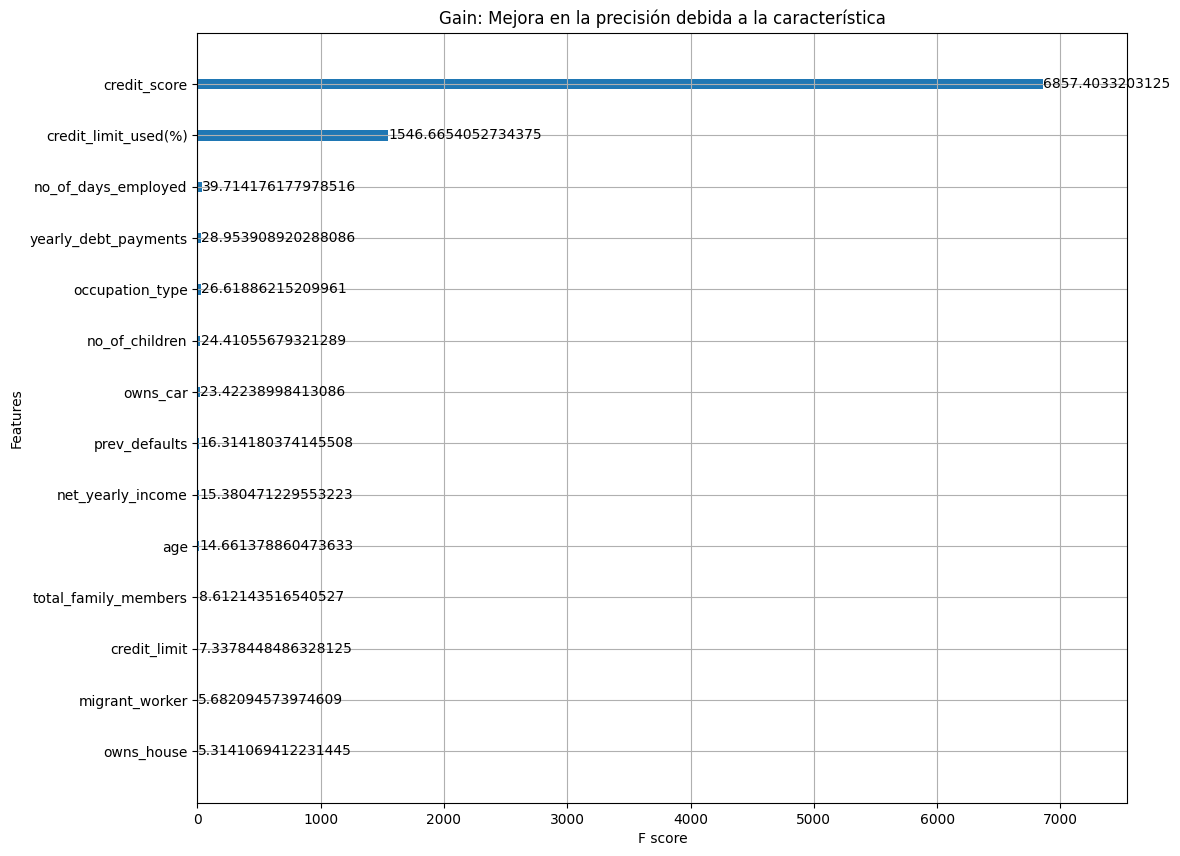

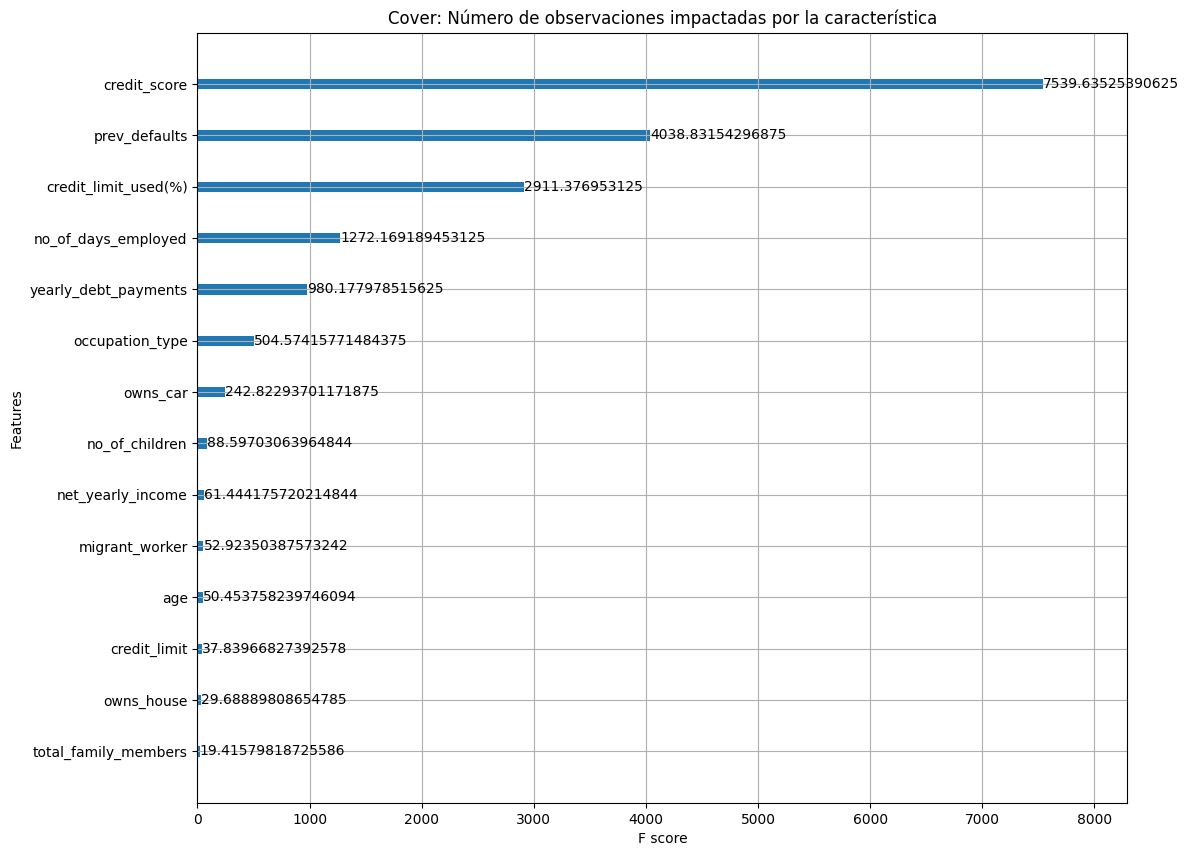

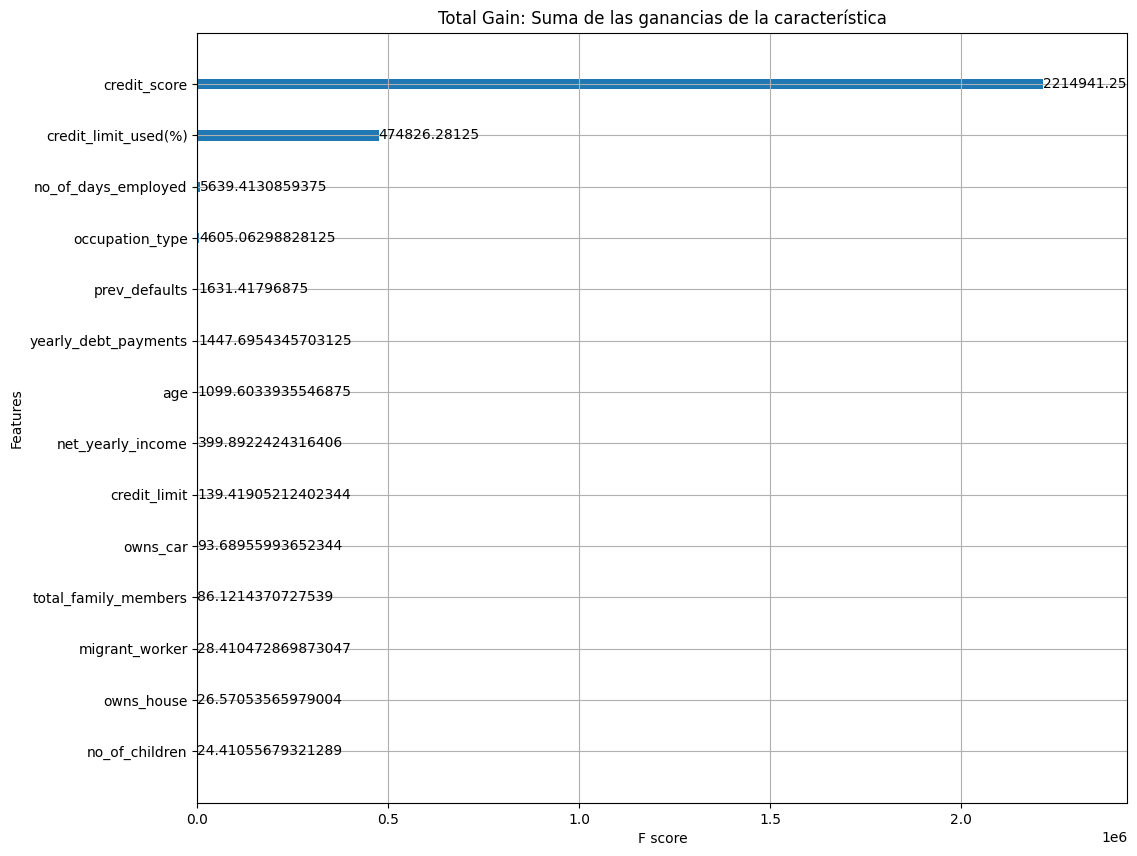

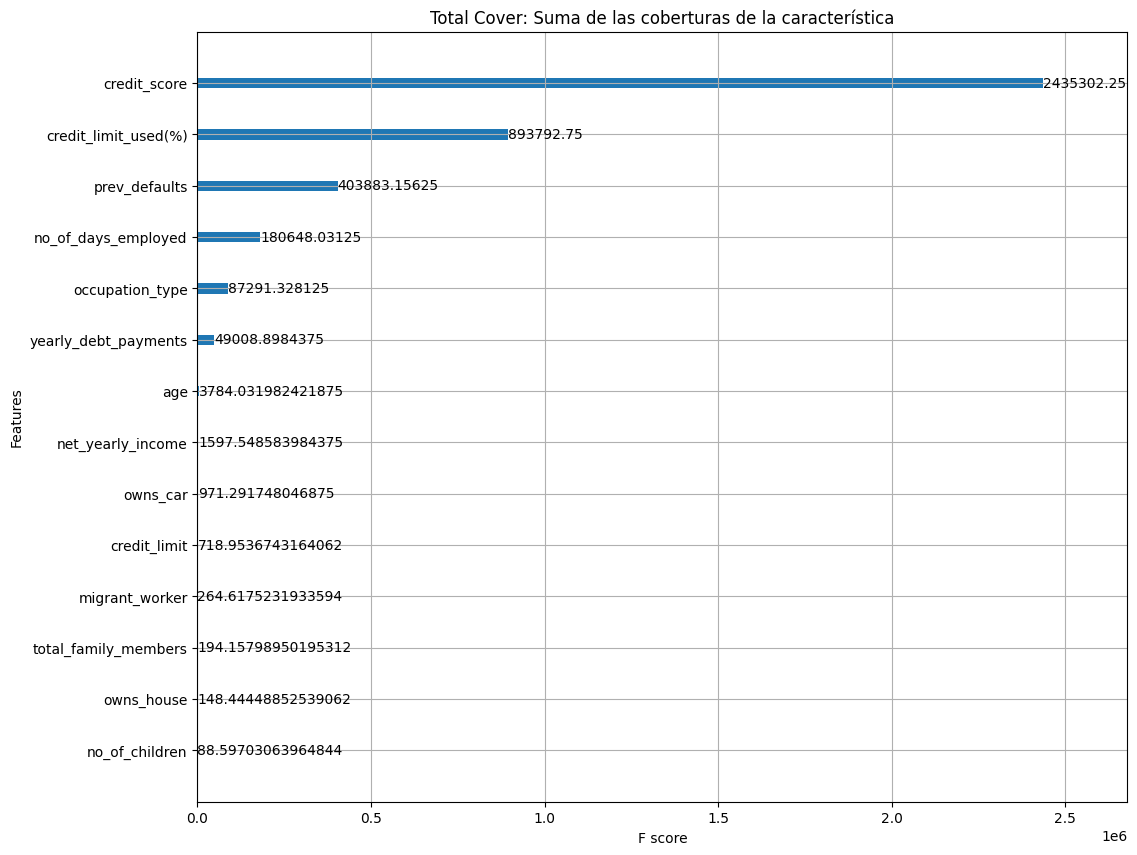

In [42]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Function to plot feature importance with specified importance type and title
def plot_importance_with_figsize(model, importance_type, title):
    fig, ax = plt.subplots(figsize=(12, 10))  # Increase figure size here
    xgb.plot_importance(model, importance_type=importance_type, ax=ax)
    ax.set_title(title)
    plt.show()

# Plot feature importance by weight
plot_importance_with_figsize(mejor_modelo, importance_type='weight', title='Weight: Frecuencia de uso de la característica en las divisiones')

# Plot feature importance by gain
plot_importance_with_figsize(mejor_modelo, importance_type='gain', title='Gain: Mejora en la precisión debida a la característica')

# Plot feature importance by cover
plot_importance_with_figsize(mejor_modelo, importance_type='cover', title='Cover: Número de observaciones impactadas por la característica')

# Plot feature importance by total gain
plot_importance_with_figsize(mejor_modelo, importance_type='total_gain', title='Total Gain: Suma de las ganancias de la característica')

# Plot feature importance by total cover
plot_importance_with_figsize(mejor_modelo, importance_type='total_cover', title='Total Cover: Suma de las coberturas de la característica')


In [86]:
#Creamos una lista con las metricas de evaluacion de los modelos
metricas = [metricas_knn, metricas_xgb]

#Convertimos la lista en un DataFrame
df_metricas = pd.DataFrame(metricas)

#Imprimimos el DataFrame
print(df_metricas)

    Modelo  Accuracy  Precision    Recall  F1 Score       AUC
0      KNN  0.941814   0.622089  0.854489   0.72000  0.902341
1  XGBoost  0.951572   0.644430  0.996904   0.78282  0.972063
